In [1]:
%pip install adversarial-robustness-toolbox
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier

c:\Users\jupap\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = '../malimg_dataset/'

In [4]:
familias = ImageDataGenerator().flow_from_directory(directory=path, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 1 classes.


In [5]:
familias.class_indices

{'malimg_paper_dataset_imgs': 0}

In [6]:
imgs, labels = next(familias)

In [7]:
imgs.shape

(9339, 64, 64, 3)

In [8]:
labels.shape

(9339, 1)

In [9]:
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(familias.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

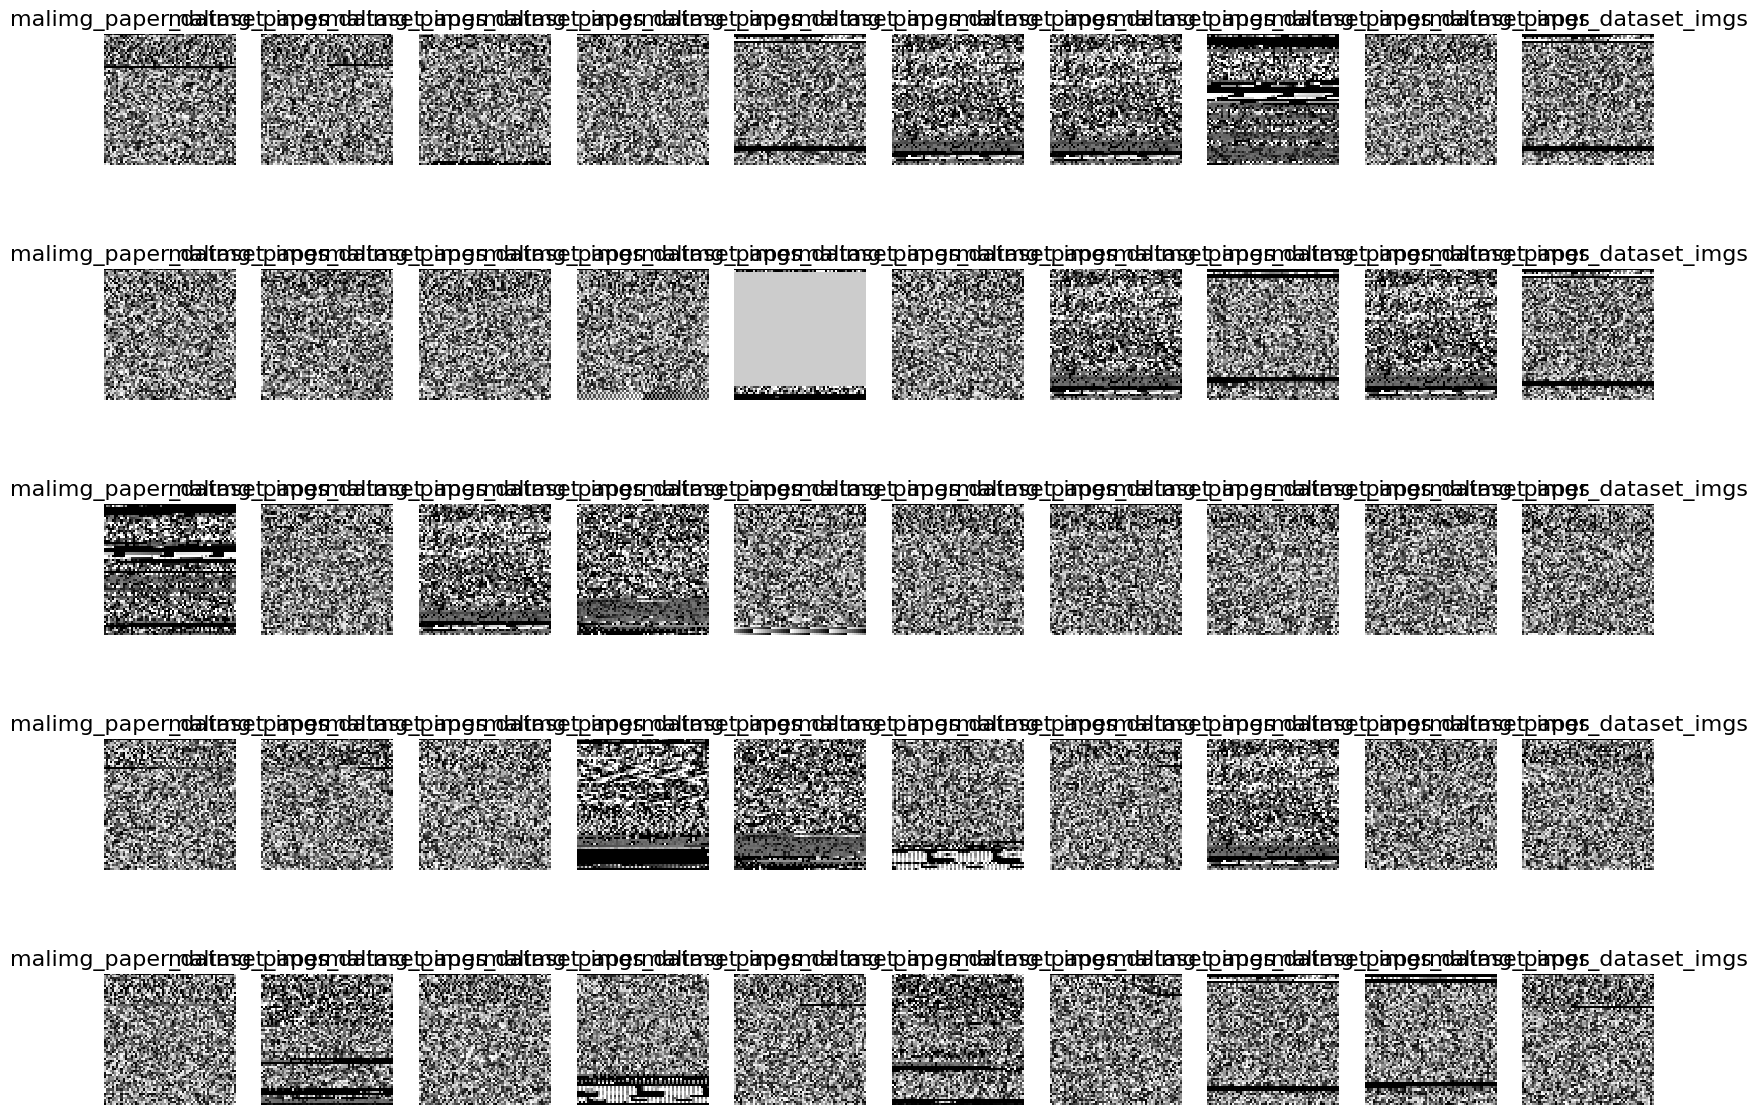

In [10]:
plots(imgs, titles = labels)

### Primera parte

In [11]:
# Create an image data generator for preprocessing
datagen = ImageDataGenerator(rescale=1./255)

# Load images
generator = datagen.flow_from_directory(
    directory=path,
    target_size=(64, 64),  # Resize images to 64x64
    batch_size=32,
    class_mode='categorical',  # or 'categorical' if more than two classes
    color_mode='rgb',
    shuffle=True
)

# Initialize lists to store the data
all_images = []
all_labels = []

# Iterate over the generator
for images, labels in generator:
    all_images.append(images)
    all_labels.append(labels)
    if len(all_images) * generator.batch_size >= generator.samples:
        break  # Ensure we don't go into an infinite loop

# Convert lists to numpy arrays
all_images = np.vstack(all_images)
all_labels = np.vstack(all_labels)

# Split data into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)

Found 9339 images belonging to 1 classes.


In [12]:
def newANN():
    model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Use 'softmax' if more than two classes
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Use 'categorical_crossentropy' for multi-class
    return model

In [13]:
model = newANN()

history = model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

model.save("first.h5")

Epoch 1/5
234/234 [==============================] - 18s 74ms/step - loss: 0.0031 - accuracy: 0.9963 - val_loss: 4.0943e-21 - val_accuracy: 1.0000
Epoch 2/5
234/234 [==============================] - 16s 70ms/step - loss: 3.1243e-10 - accuracy: 1.0000 - val_loss: 4.0777e-21 - val_accuracy: 1.0000
Epoch 3/5
234/234 [==============================] - 16s 70ms/step - loss: 3.1098e-10 - accuracy: 1.0000 - val_loss: 4.0579e-21 - val_accuracy: 1.0000
Epoch 4/5
234/234 [==============================] - 16s 70ms/step - loss: 3.0934e-10 - accuracy: 1.0000 - val_loss: 4.0313e-21 - val_accuracy: 1.0000
Epoch 5/5
234/234 [==============================] - 16s 70ms/step - loss: 3.0724e-10 - accuracy: 1.0000 - val_loss: 4.0001e-21 - val_accuracy: 1.0000


c:\Users\jupap\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


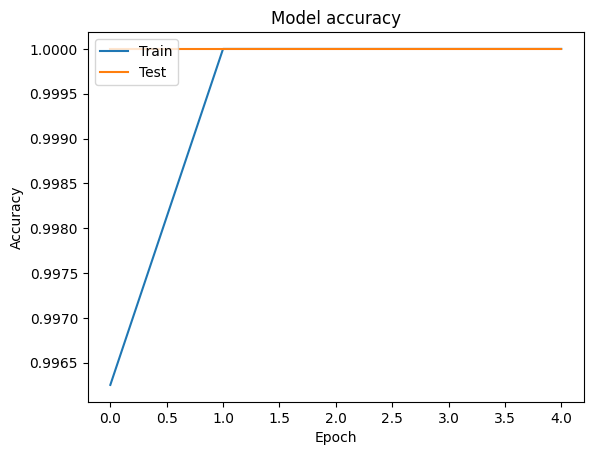

59/59 - 1s - loss: 4.0001e-21 - accuracy: 1.0000 - 741ms/epoch - 13ms/step
Test accuracy: 100.00%


In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc*100:.2f}%")

### Segunda parte

Cargando el modelo

In [15]:
model = load_model('first.h5')

classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=2,  # Adjust based on your number of classes
    input_shape=(64, 64, 3),
    loss_object=tf.keras.losses.BinaryCrossentropy(),  # Use CategoricalCrossentropy for multi-class
    clip_values=(0, 1)
)

Ataque de evasión

In [16]:
# Fast Gradient Sign Method (FGSM) Attack
fgsm_attack = FastGradientMethod(estimator=classifier, eps=0.1)
x_train_adv = fgsm_attack.generate(x=train_images)

In [17]:
# Combine the original and adversarial examples
x_train_combined = np.concatenate((train_images, x_train_adv), axis=0)
y_train_combined = np.concatenate((train_labels, train_labels), axis=0)  # Labels remain the same for adversarial examples

In [18]:
# Train the model on the combined dataset
model = newANN()  # Assuming newANN() is your function to create a new model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Adjust loss if using categorical

history = model.fit(x_train_combined, y_train_combined, epochs=5, validation_data=(test_images, test_labels))

Epoch 1/5
467/467 [==============================] - 33s 70ms/step - loss: 0.0015 - accuracy: 0.9993 - val_loss: 5.9428e-22 - val_accuracy: 1.0000
Epoch 2/5
467/467 [==============================] - 32s 68ms/step - loss: 5.3652e-11 - accuracy: 1.0000 - val_loss: 5.9340e-22 - val_accuracy: 1.0000
Epoch 3/5
467/467 [==============================] - 32s 68ms/step - loss: 5.3452e-11 - accuracy: 1.0000 - val_loss: 5.9213e-22 - val_accuracy: 1.0000
Epoch 4/5
467/467 [==============================] - 32s 68ms/step - loss: 5.3202e-11 - accuracy: 1.0000 - val_loss: 5.9036e-22 - val_accuracy: 1.0000
Epoch 5/5
467/467 [==============================] - 32s 68ms/step - loss: 5.2927e-11 - accuracy: 1.0000 - val_loss: 5.8837e-22 - val_accuracy: 1.0000


In [19]:
# Evaluate the model on normal test data
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy on normal examples: {test_acc*100:.2f}%")

# Evaluate the model on adversarial test data
x_test_adv = fgsm_attack.generate(x=test_images)
test_loss_adv, test_acc_adv = model.evaluate(x_test_adv, test_labels, verbose=2)
print(f"Test accuracy on adversarial examples: {test_acc_adv*100:.2f}%")

59/59 - 1s - loss: 5.8837e-22 - accuracy: 1.0000 - 691ms/epoch - 12ms/step
Test accuracy on normal examples: 100.00%
59/59 - 1s - loss: 5.7003e-20 - accuracy: 1.0000 - 773ms/epoch - 13ms/step
Test accuracy on adversarial examples: 100.00%


Ataque de inferencia

In [20]:
def temperature_scaled_softmax(logits, temperature=2.0):
    scaled_logits = logits / temperature
    return tf.nn.softmax(scaled_logits)

In [21]:
def temperature_scaled_softmax(logits, temperature=2.0):
    """Applies temperature scaling to logits before softmax."""
    scaled_logits = logits / temperature
    return tf.nn.softmax(scaled_logits)

# Modify your model to use temperature scaling in the output layer
def newANN_with_temperature_scaling():
    model = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation=lambda x: temperature_scaled_softmax(x, temperature=2.0))  # Assuming 10 classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
model = newANN_with_temperature_scaling()  # Use the model with differential privacy

# Load your data
train_images, train_labels = ...  # Load your training data
test_images, test_labels = ...    # Load your testing data

# Train the model
history = model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

TypeError: cannot unpack non-iterable ellipsis object

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc*100:.2f}%")